In [1]:
# 1. Vérifie que le GPU est actif
!nvidia-smi

# 2. Installe les dépendances système (ffmpeg pour la vidéo)
!apt -y install ffmpeg

# 3. Clone le dépôt SAM3 de Meta si pas déjà fait
!git clone https://github.com/facebookresearch/sam3.git || echo "Already cloned"
%cd sam3

# 4. Installe SAM3 et ses dépendances de base
!pip install -e .

# 5. Installe les extras pour les notebooks uniquement
!pip install -e ".[notebooks]"


Wed Nov 26 13:02:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   66C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# 6. Authentification Hugging Face (nécessaire pour télécharger les poids SAM3)
from huggingface_hub import login
login()  # Entrer ici ton token Hugging Face (copié depuis https://huggingface.co/settings/tokens)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
from google.colab import files
uploaded = files.upload()  # Choisis ton .mp4 localement

Saving extrait_202502061000_D04.mp4 to extrait_202502061000_D04 (2).mp4


In [3]:
from sam3.model_builder import build_sam3_video_predictor

video_predictor = build_sam3_video_predictor()
video_path = "extrait_202502061000_D04.mp4" # a JPEG folder or an MP4 video file

# Start a session
response = video_predictor.handle_request(
    request=dict(
        type="start_session",
        resource_path=video_path,
    )
)
session_id = response["session_id"]

response = video_predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=response["session_id"],
        frame_index=0, # Arbitrary frame index
        text="cow",
    )
)
output = response["outputs"]


INFO 2025-11-26 13:03:17,039 26279 sam3_video_predictor.py: 299: using the following GPU IDs: [0]
INFO 2025-11-26 13:03:17,040 26279 sam3_video_predictor.py: 315: 


	*** START loading model on all ranks ***


INFO 2025-11-26 13:03:17,041 26279 sam3_video_predictor.py: 317: loading model on rank=0 with world_size=1 -- this could take a while ...
INFO 2025-11-26 13:03:29,701 26279 sam3_video_base.py: 124: setting max_num_objects=10000 and num_obj_for_compile=16
INFO 2025-11-26 13:03:48,686 26279 sam3_video_predictor.py: 319: loading model on rank=0 with world_size=1 -- DONE locally
INFO 2025-11-26 13:03:48,687 26279 sam3_video_predictor.py: 330: 


	*** DONE loading model on all ranks ***


frame loading (OpenCV) [rank=0]:  94%|█████████▍| 120/128 [00:02<00:00, 56.01it/s]


In [ ]:
def propagate_in_video(predictor, session_id):
    # we will just propagate from frame 0 to the end of the video
    outputs_per_frame = {}
    for response in predictor.handle_stream_request(
        request=dict(
            type="propagate_in_video",
            session_id=session_id,
        )
    ):
        outputs_per_frame[response["frame_index"]] = response["outputs"]

    return outputs_per_frame

# now we propagate the outputs from frame 0 to the end of the video and collect all outputs
outputs_per_frame = propagate_in_video(video_predictor, session_id)


In [ ]:
# finally, we reformat the outputs for visualization and plot the outputs every 60 frames
import matplotlib.pyplot as plt
from sam3.visualization_utils import (
    prepare_masks_for_visualization,
    visualize_formatted_frame_output,
)

outputs_per_frame_prep = prepare_masks_for_visualization(outputs_per_frame)

import cv2

cap = cv2.VideoCapture(video_path)
video_frames_for_vis = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    video_frames_for_vis.append(frame_rgb)

cap.release()



vis_frame_stride = 60
plt.close("all")
for frame_idx in range(0, len(outputs_per_frame_prep), vis_frame_stride):
    visualize_formatted_frame_output(
        frame_idx,
        video_frames_for_vis,
        outputs_list=[outputs_per_frame_prep],
        titles=["SAM 3 Dense Tracking outputs"],
        figsize=(6, 4),
    )


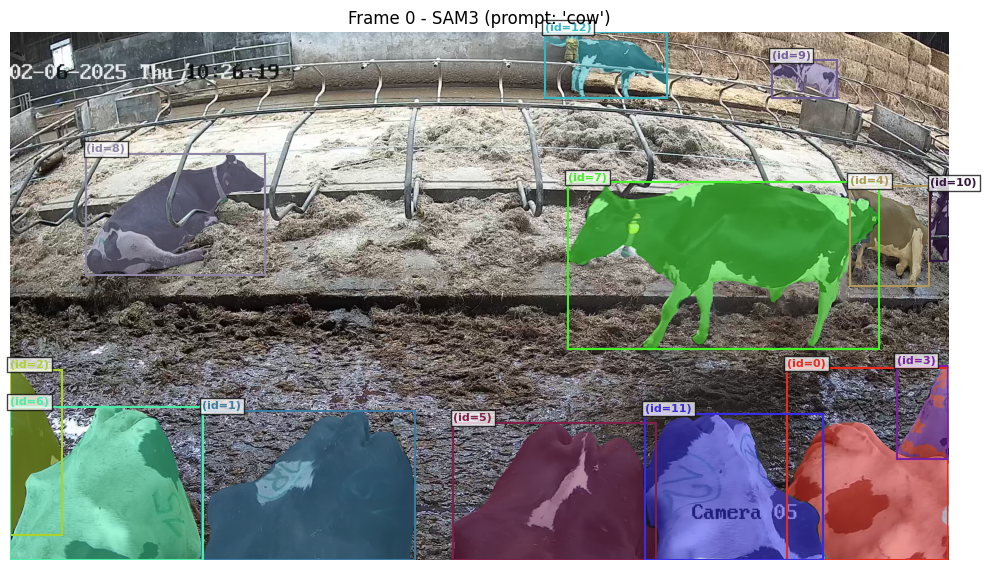

In [22]:
#juste pour avoir le tracking sur la première frame
import cv2
import matplotlib.pyplot as plt
from sam3.visualization_utils import (
    prepare_masks_for_visualization,
    visualize_formatted_frame_output,
)

# 1. Lire la première frame
cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
cap.release()

assert ret, "Erreur : impossible de lire la première frame"
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# 2. Formater les outputs SAM3
outputs_formatted = prepare_masks_for_visualization({0: output})

# 3. Affichage SAM3 — AVEC frame_idx en premier argument
plt.close("all")
visualize_formatted_frame_output(
    0,                        # <== frame_idx requis ici !
    [frame_rgb],              # video_frames (liste même pour 1)
    outputs_list=[outputs_formatted],
    titles=["SAM3 (prompt: 'cow')"],
    figsize=(10, 6),
)


In [ ]:
# On propage aux autres frames :
def propagate_in_video(predictor, session_id):
    outputs_per_frame = {}
    for response in predictor.handle_stream_request(
        request=dict(
            type="propagate_in_video",
            session_id=session_id,
        )
    ):
        outputs_per_frame[response["frame_index"]] = response["outputs"]
    return outputs_per_frame

outputs_per_frame = propagate_in_video(video_predictor, response["session_id"])
